# CAISO Energy Storage Bid Analysis

<b>Author:</b> Neal Ma

<b>Date created:</b> October 15, 2024

<b>Description:</b> This notebook contains final visualization and statistical analyses for CAISO energy storage bids from July 1, 2023 - October 1, 2024. 

CAISO Energy Storage Daily Reports:

LCG Consulting Day-Ahead CAISO Prices:

LCG Consulting Real-Time CAISO Prices:


## Notebook Setup and Data Preprocessing

In [39]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import matplotlib.dates as mdates
import math
from scipy.stats import ks_2samp
import os


# enable tex for graphs
matplotlib.rc("text", usetex=True)
matplotlib.rc("font", family="serif")

In [40]:
# read energy storage data


ES_df = pd.read_parquet("./data/ES_BIDS/CAISO_ES_BIDS.parquet")


# read real-time price data


RT_df = pd.read_csv("./data/CAISO_RTP.csv")


RT_df["Date"] = pd.to_datetime(RT_df["Date"], format="%m/%d/%Y %I:%M:%S %p")


RT_df = RT_df.drop_duplicates(subset=["Date", "hub"])


RT_df = RT_df.pivot(index="Date", columns="hub", values="price")


# read day-ahead price data


# TODO: Do this
# Directory containing the CSV files


dap_csv_dir = "./data/DAP_CSV/"

# List to hold dataframes
dap_dfs = []

# Read each CSV file and append to the list
for file_name in os.listdir(dap_csv_dir):
    if file_name.endswith(".csv"):
        file_path = os.path.join(dap_csv_dir, file_name)
        dap_dfs.append(pd.read_csv(file_path))

# Concatenate all dataframes
combined_dap_df = pd.concat(dap_dfs)

# Write the combined dataframe to a single CSV file
combined_dap_df.to_csv("./data/CAISO_DAP.csv", index=False)

DA_df = pd.read_csv("./data/CAISO_DAP.csv")


DA_df["Date"] = pd.to_datetime(DA_df["Date"], format="%m/%d/%Y %I:%M:%S %p")


DA_df = DA_df.drop_duplicates(subset=["Date", "zone"])


DA_df = DA_df.pivot(index="Date", columns="zone", values="price")

In [41]:
# merge dataframes
full_df = ES_df.join(RT_df, how="outer")
full_df = full_df.join(DA_df, how="outer")

# filter for data between July 1, 2023 and October 1, 2024
full_df = full_df[
    (full_df.index >= pd.Timestamp("July 1, 2023"))
    & (full_df.index <= pd.Timestamp("October 1, 2024"))
]

hubs = ["TH_NP15", "TH_SP15", "TH_ZP26"]
zones = ["PGAE", "SCE", "SDGE", "VEA"]

# track min, max, avg real-time prices for all timestamps
full_df["rt_price_max"] = full_df[hubs].max(axis=1)
full_df["rt_price_min"] = full_df[hubs].min(axis=1)
full_df["rt_price_avg"] = full_df[hubs].mean(axis=1)

# track min, max, avg day-ahead prices for all timestamps
full_df["da_price_max"] = full_df[zones].max(axis=1)
full_df["da_price_min"] = full_df[zones].min(axis=1)
full_df["da_price_avg"] = full_df[zones].mean(axis=1)

In [42]:
bid_segments = {
    "ss": "Self Schedule",
    "1": "[-150, -100]",
    "2": "(-100, -50]",
    "3": "(-50, -15]",
    "4": "(-15, 0]",
    "5": "(0, 15]",
    "6": "(15, 50]",
    "7": "(50, 100]",
    "8": "(100, 200]",
    "9": "(200, 500]",
    "10": "(500, 1000]",
    "11": "(1000, 2000]",
}

bid_segment_edges = [-150, -100, -50, -15, 0, 15, 50, 100, 200, 500, 1000, 2000]
bid_segment_weights = [
    (bid_segment_edges[i] + bid_segment_edges[i + 1]) / 2.0
    for i in range(len(bid_segment_edges) - 1)
]


def add_prop_weighted_columns(data: pd.DataFrame = None, exclude_ss: bool = True):
    bid_columns = [col for col in data.columns if "bid" in col]
    if exclude_ss:
        bid_columns = [col for col in bid_columns if "ss" not in col]

    bid_types = ["rtpd_neg", "rtpd_pos", "ifm_neg", "ifm_pos"]
    for type in bid_types:
        data[f"bid_{type}_tot"] = sum([data[col] for col in bid_columns if type in col])
        type_cols = [col for col in bid_columns if type in col]
        for col in type_cols:
            data[f"{col}_prop"] = data[col] / data[f"bid_{type}_tot"]

        prop_cols = [f"bid_{type}_{val + 1}_prop" for val in range(11)]
        data[f"bid_{type}_weighted"] = np.dot(data[prop_cols], bid_segment_weights)

    data["bid_rtpd_weighted_spread"] = (
        data["bid_rtpd_pos_weighted"] - data["bid_rtpd_neg_weighted"]
    )

    data["bid_ifm_weighted_spread"] = (
        data["bid_ifm_pos_weighted"] - data["bid_ifm_neg_weighted"]
    )

    return data

In [43]:
# build daily aggregations (mean)
daily_df = full_df.resample("D").mean()
hourly_df = full_df.resample("h").mean()

daily_df = add_prop_weighted_columns(data=daily_df, exclude_ss=True)
hourly_df = add_prop_weighted_columns(data=hourly_df, exclude_ss=True)

## Price Spike Identification

We define a price spike as anytime where the minimum price in CAISO exceeds two standard deviations above the average mean daily price

In [34]:
def identify_spikes(
    data: pd.DataFrame = None,
    start_date: pd.Timestamp = None,
    end_date: pd.Timestamp = None,
    column: str = "",
    std_threshold: int = 2,
    graph=True,
    description: str = "",
):
    """
    Identifies and returns all timestamps in data where column value exceeds std_threshold above the mean of column value.
    Graphing feature can be activated/deactivated and further tuned using start_date and end_date.
    """
    # copy data
    data_copy = data.copy()
    description = column if description == "" else description

    # determine distribution statistics
    mean = data_copy[column].mean()
    std = data_copy[column].std()
    threshold = mean + std_threshold * std
    abnormal_timestamps = data_copy[data[column] > threshold].index

    if graph:
        plt.figure(figsize=(14, 7))
        if start_date:
            data_copy = data_copy[data.index >= start_date]
        if end_date:
            data_copy = data_copy[data.index <= end_date]
        plt.plot(
            data_copy.index,
            data_copy[column],
            color="black",
            label=description,
            linewidth=0.5,
        )
        plt.axhline(
            y=threshold,
            color="r",
            linestyle="--",
            label=r"$\mu +$" + str(std_threshold) + r"$\sigma$",
        )

        filtered_abnormal_timestamps = abnormal_timestamps.copy()
        if start_date:
            filtered_abnormal_timestamps = [
                date for date in filtered_abnormal_timestamps if date >= start_date
            ]
        if end_date:
            filtered_abnormal_timestamps = [
                date for date in filtered_abnormal_timestamps if date <= end_date
            ]

        for idx, timestamp in enumerate(filtered_abnormal_timestamps):
            plt.axvline(
                x=timestamp,
                color="green",
                alpha=0.4,
                label=("Price Spike" if idx == 0 else None),
            )
        plt.legend()
        plt.title(f"Abnormality Detection in {description}")
        plt.xlabel("Date")
        plt.ylabel("Price (USD/MWh)")
        plt.show()

    del data_copy

    return abnormal_timestamps

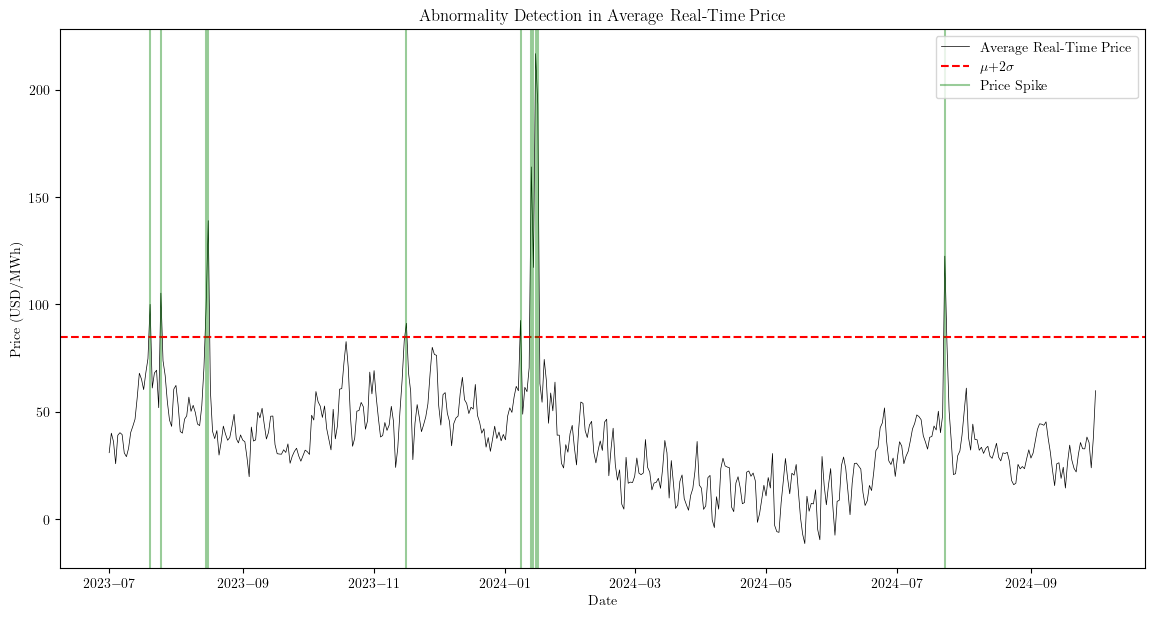

DatetimeIndex(['2023-07-20', '2023-07-25', '2023-08-15', '2023-08-16',
               '2023-11-16', '2024-01-08', '2024-01-13', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-07-23'],
              dtype='datetime64[ns]', freq=None)


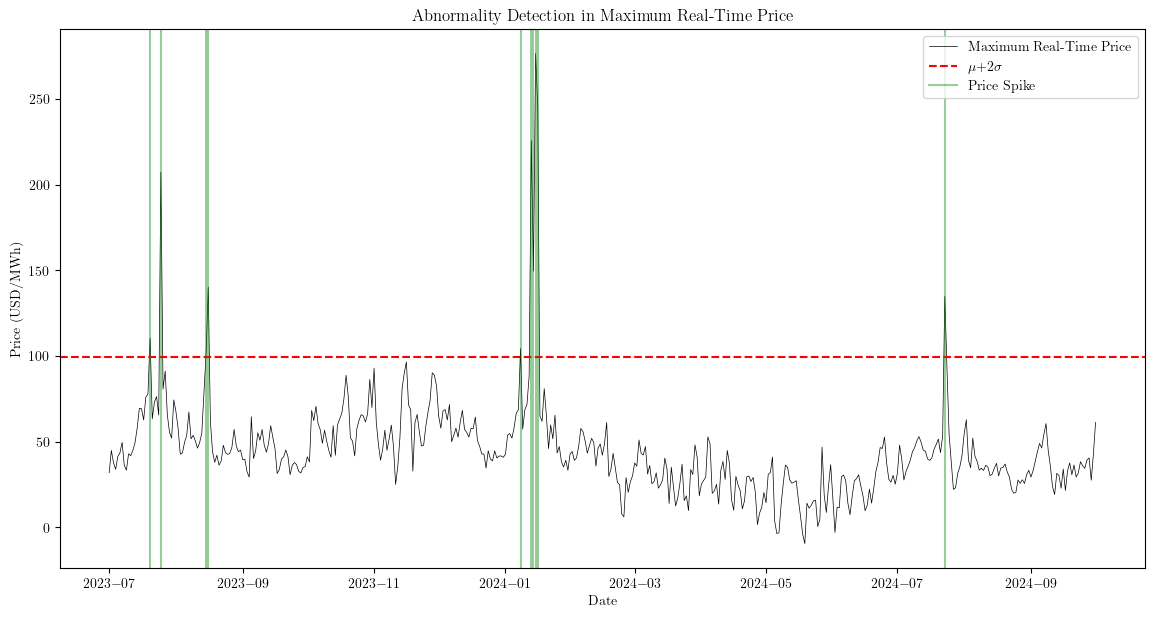

DatetimeIndex(['2023-07-20', '2023-07-25', '2023-08-15', '2023-08-16',
               '2024-01-08', '2024-01-13', '2024-01-14', '2024-01-15',
               '2024-01-16', '2024-07-23'],
              dtype='datetime64[ns]', freq=None)


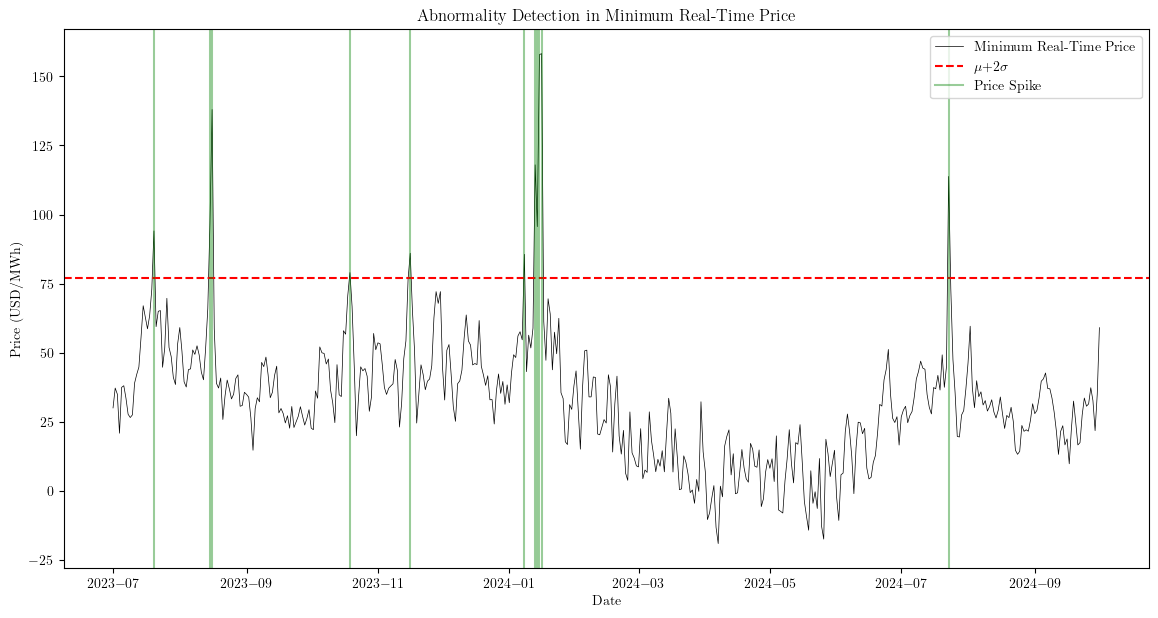

DatetimeIndex(['2023-07-20', '2023-08-15', '2023-08-16', '2023-10-19',
               '2023-11-16', '2024-01-08', '2024-01-13', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-07-23'],
              dtype='datetime64[ns]', freq=None)


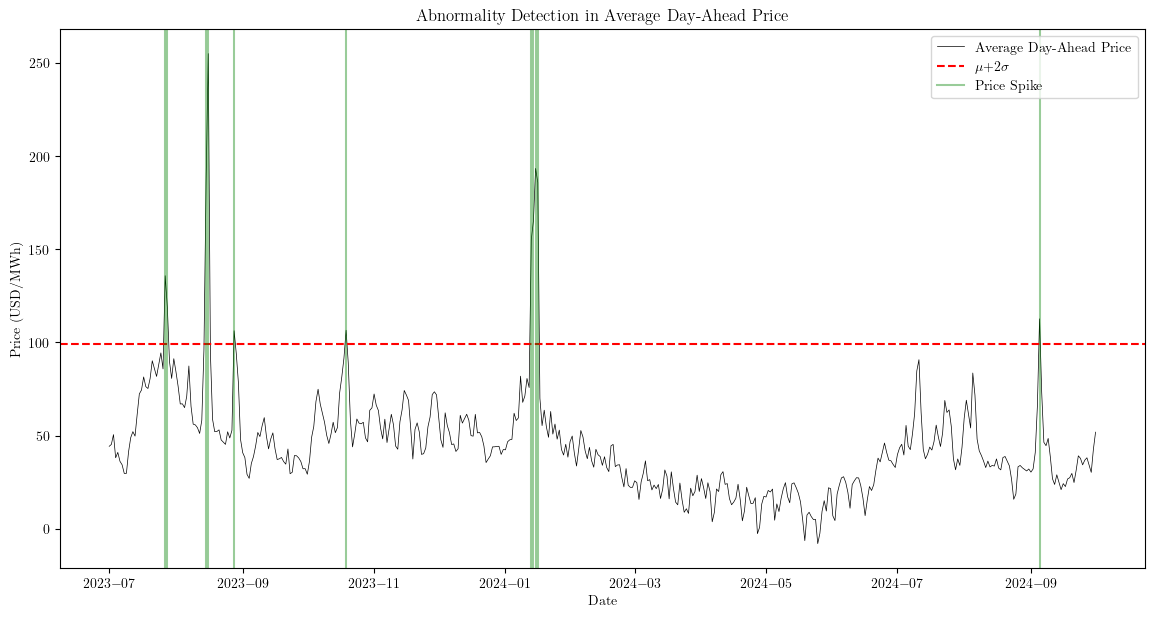

DatetimeIndex(['2023-07-27', '2023-07-28', '2023-08-15', '2023-08-16',
               '2023-08-28', '2023-10-19', '2024-01-13', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


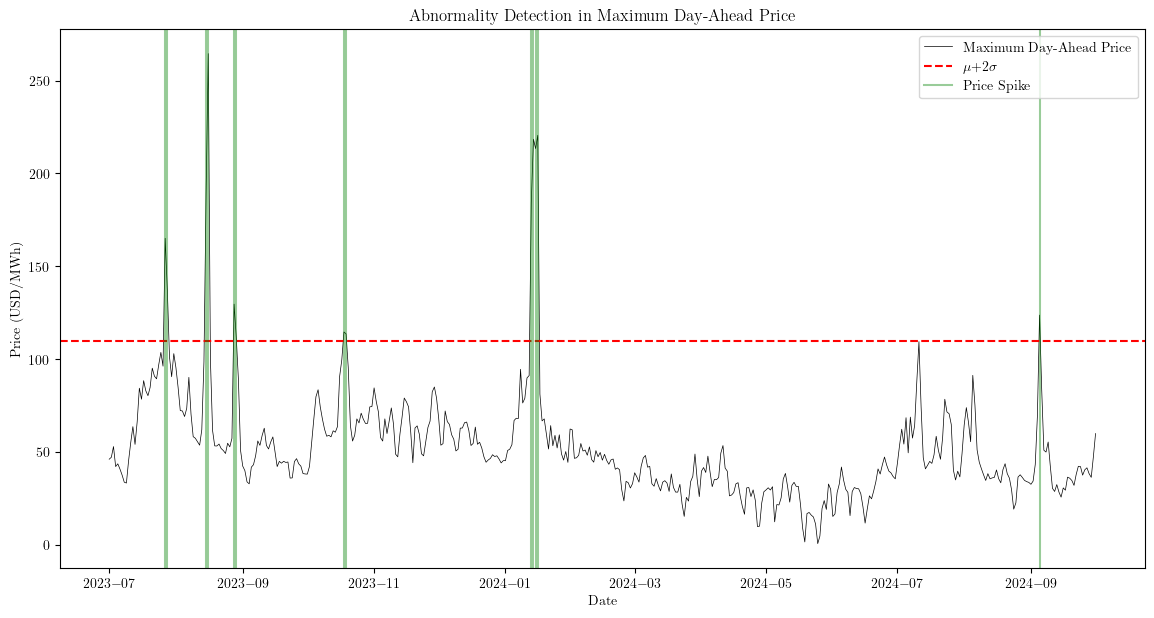

DatetimeIndex(['2023-07-27', '2023-07-28', '2023-08-15', '2023-08-16',
               '2023-08-28', '2023-08-29', '2023-10-18', '2023-10-19',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


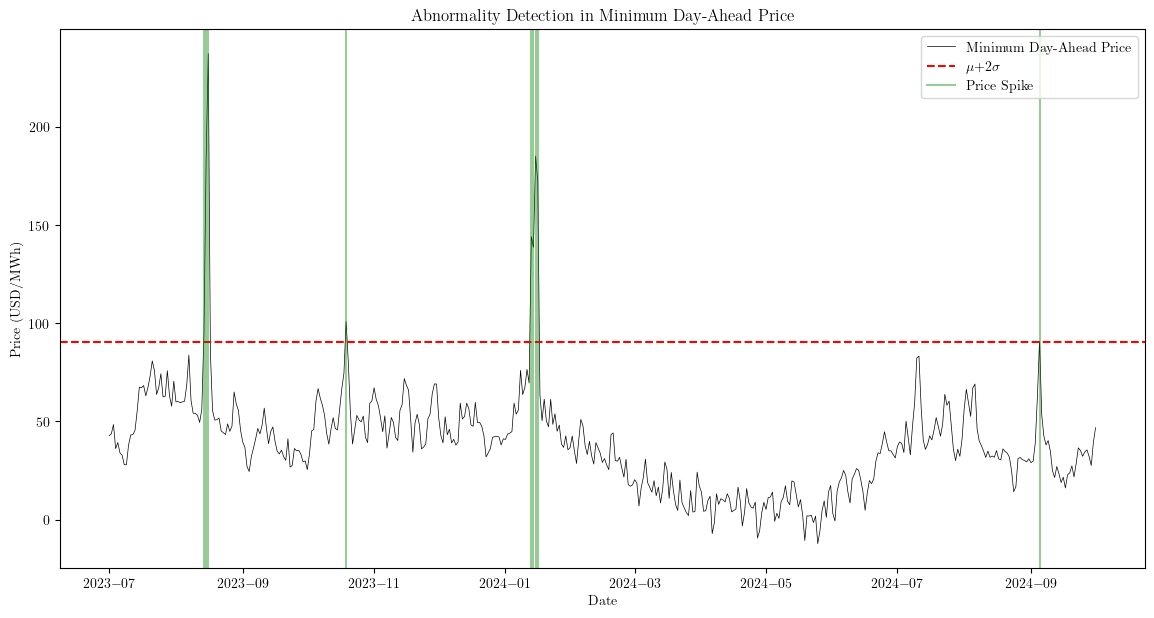

DatetimeIndex(['2023-08-14', '2023-08-15', '2023-08-16', '2023-10-19',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


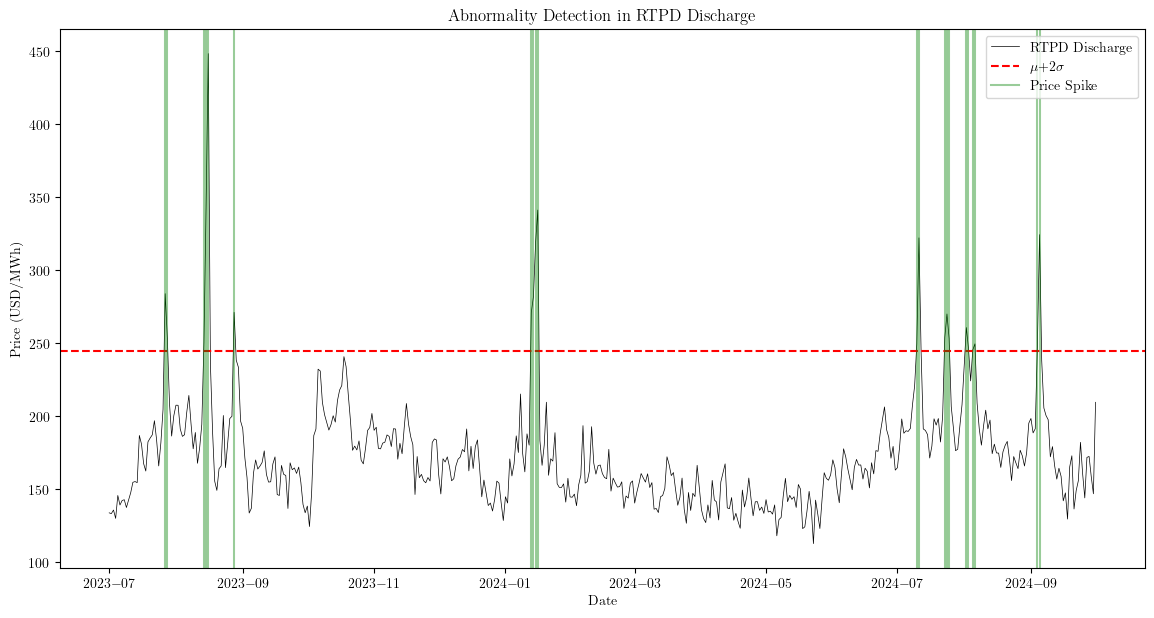

DatetimeIndex(['2023-07-27', '2023-07-28', '2023-08-14', '2023-08-15',
               '2023-08-16', '2023-08-28', '2024-01-13', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-07-10', '2024-07-11',
               '2024-07-23', '2024-07-24', '2024-07-25', '2024-08-02',
               '2024-08-03', '2024-08-05', '2024-08-06', '2024-09-04',
               '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


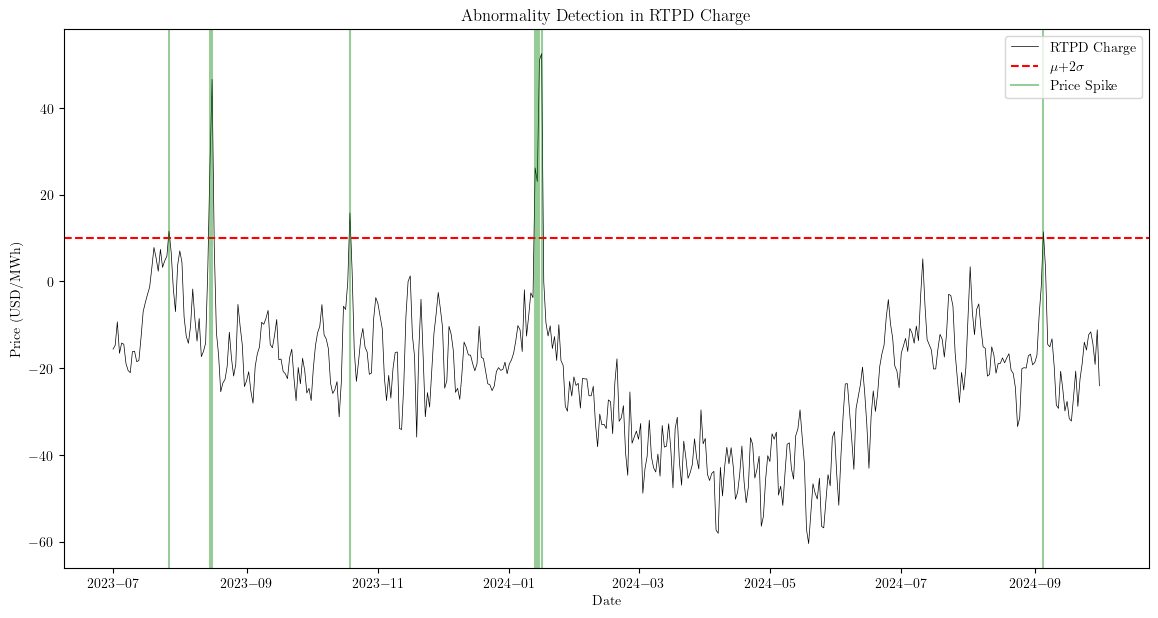

DatetimeIndex(['2023-07-27', '2023-08-15', '2023-08-16', '2023-10-19',
               '2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16',
               '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


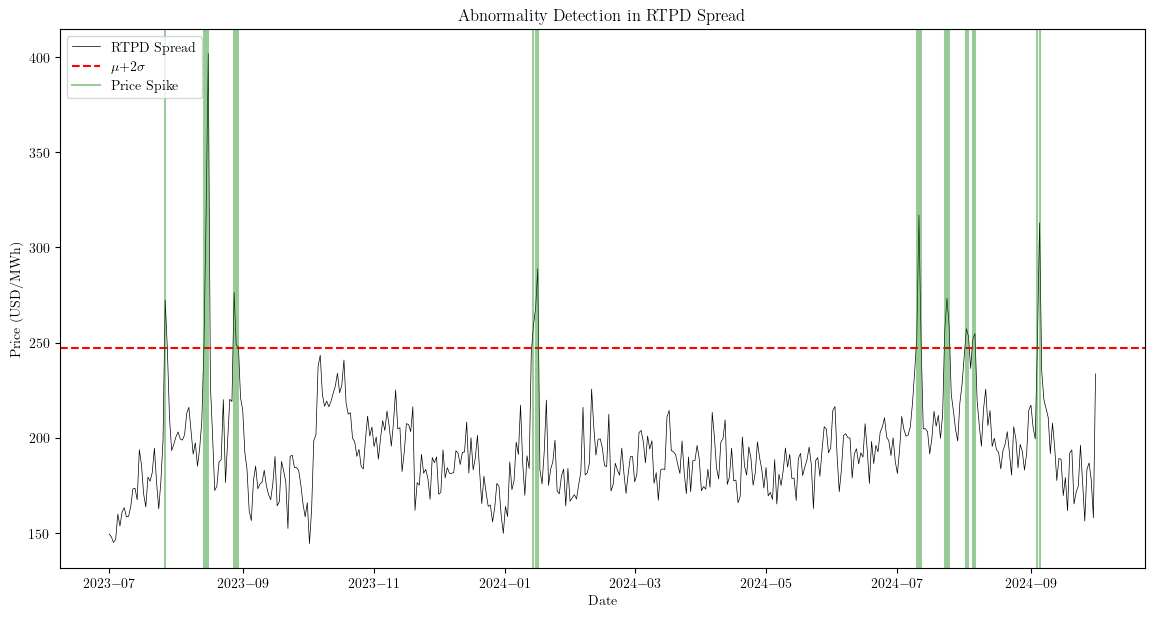

DatetimeIndex(['2023-07-27', '2023-08-14', '2023-08-15', '2023-08-16',
               '2023-08-28', '2023-08-29', '2023-08-30', '2024-01-14',
               '2024-01-15', '2024-01-16', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-23', '2024-07-24', '2024-07-25',
               '2024-08-02', '2024-08-03', '2024-08-05', '2024-08-06',
               '2024-09-04', '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


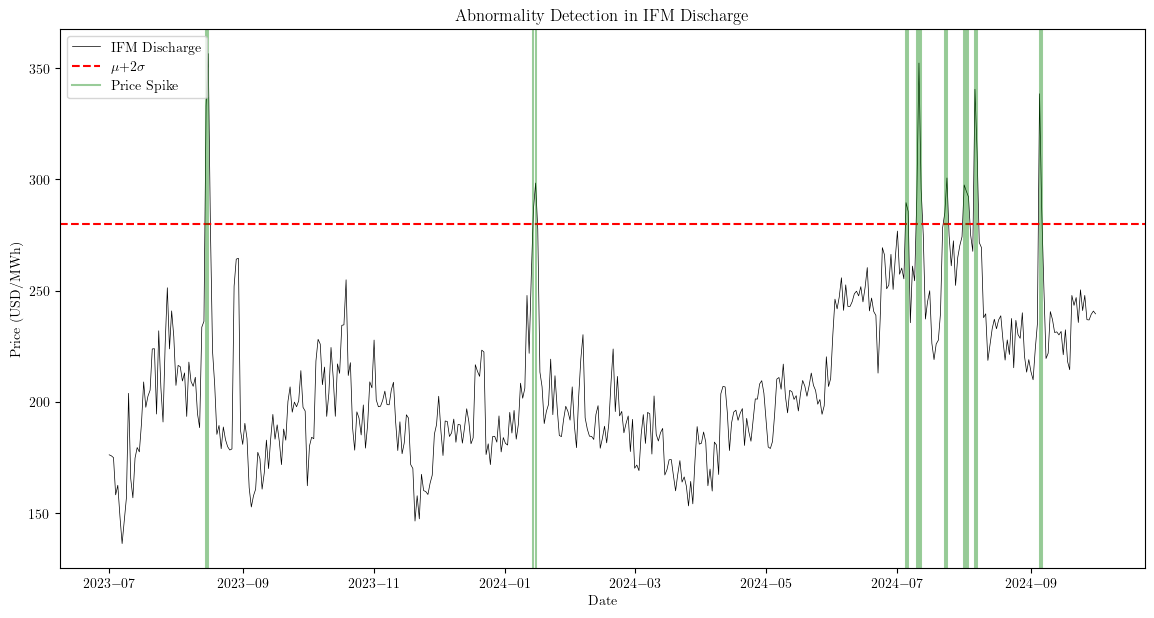

DatetimeIndex(['2023-08-15', '2023-08-16', '2024-01-14', '2024-01-15',
               '2024-07-05', '2024-07-06', '2024-07-10', '2024-07-11',
               '2024-07-12', '2024-07-23', '2024-07-24', '2024-08-01',
               '2024-08-02', '2024-08-03', '2024-08-06', '2024-08-07',
               '2024-09-05', '2024-09-06'],
              dtype='datetime64[ns]', freq=None)


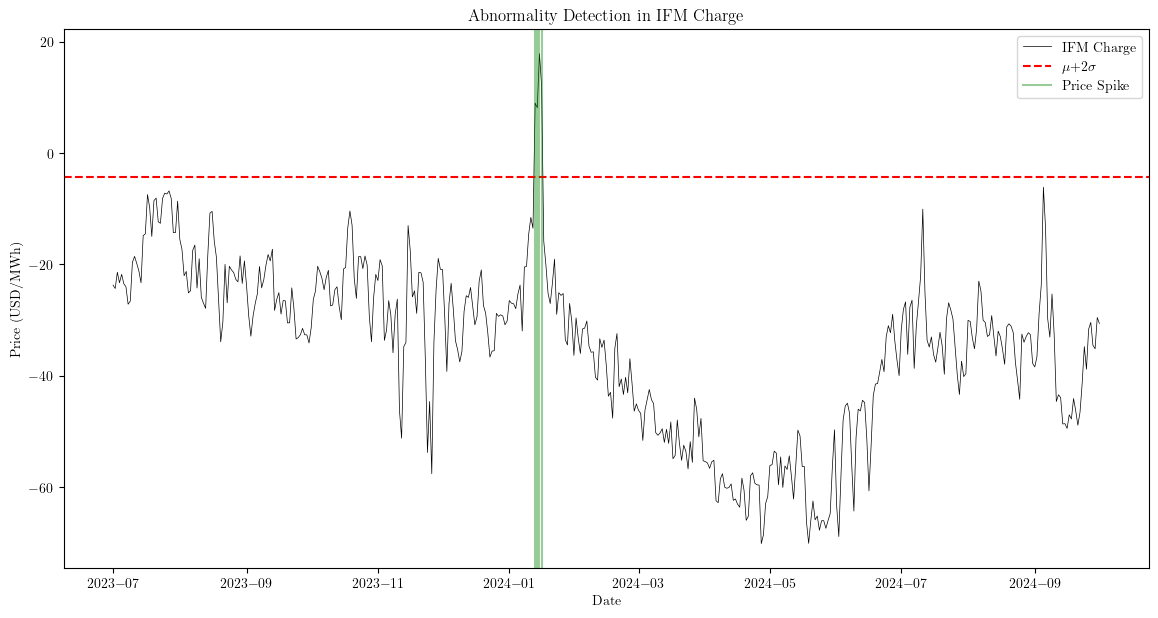

DatetimeIndex(['2024-01-13', '2024-01-14', '2024-01-15', '2024-01-16'], dtype='datetime64[ns]', freq='D')


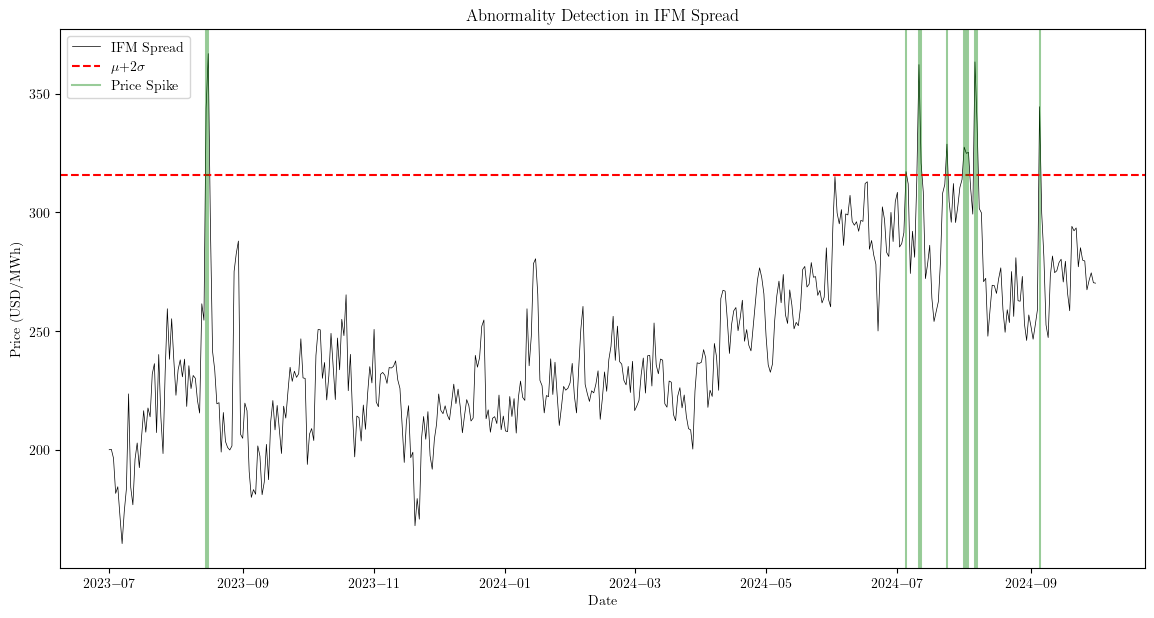

DatetimeIndex(['2023-08-15', '2023-08-16', '2024-07-05', '2024-07-11',
               '2024-07-12', '2024-07-24', '2024-08-01', '2024-08-02',
               '2024-08-03', '2024-08-06', '2024-08-07', '2024-09-05'],
              dtype='datetime64[ns]', freq=None)


In [44]:
RTP_spike_days_avg = identify_spikes(
    data=daily_df, column="rt_price_avg", description="Average Real-Time Price"
)
print(RTP_spike_days_avg)

RTP_spike_days_max = identify_spikes(
    data=daily_df, column="rt_price_max", description="Maximum Real-Time Price"
)
print(RTP_spike_days_max)

RTP_spike_days_min = identify_spikes(
    data=daily_df, column="rt_price_min", description="Minimum Real-Time Price"
)
print(RTP_spike_days_min)

DAP_spike_days_avg = identify_spikes(
    data=daily_df, column="da_price_avg", description="Average Day-Ahead Price"
)
print(DAP_spike_days_avg)

DAP_spike_days_max = identify_spikes(
    data=daily_df, column="da_price_max", description="Maximum Day-Ahead Price"
)
print(DAP_spike_days_max)

DAP_spike_days_min = identify_spikes(
    data=daily_df, column="da_price_min", description="Minimum Day-Ahead Price"
)
print(DAP_spike_days_min)

RTPD_discharge_days = identify_spikes(
    data=daily_df, column="bid_rtpd_pos_weighted", description="RTPD Discharge"
)
print(RTPD_discharge_days)

RTPD_charge_days = identify_spikes(
    data=daily_df, column="bid_rtpd_neg_weighted", description="RTPD Charge"
)
print(RTPD_charge_days)

RTPD_spread_days = identify_spikes(
    data=daily_df, column="bid_rtpd_weighted_spread", description="RTPD Spread"
)
print(RTPD_spread_days)

IFM_discharge_days = identify_spikes(
    data=daily_df, column="bid_ifm_pos_weighted", description="IFM Discharge"
)
print(IFM_discharge_days)

IFM_charge_days = identify_spikes(
    data=daily_df, column="bid_ifm_neg_weighted", description="IFM Charge"
)
print(IFM_charge_days)

IFM_spread_days = identify_spikes(
    data=daily_df, column="bid_ifm_weighted_spread", description="IFM Spread"
)
print(IFM_spread_days)

## Hourly Weighted Bids on Price Spike vs. Non-Price Spike Days

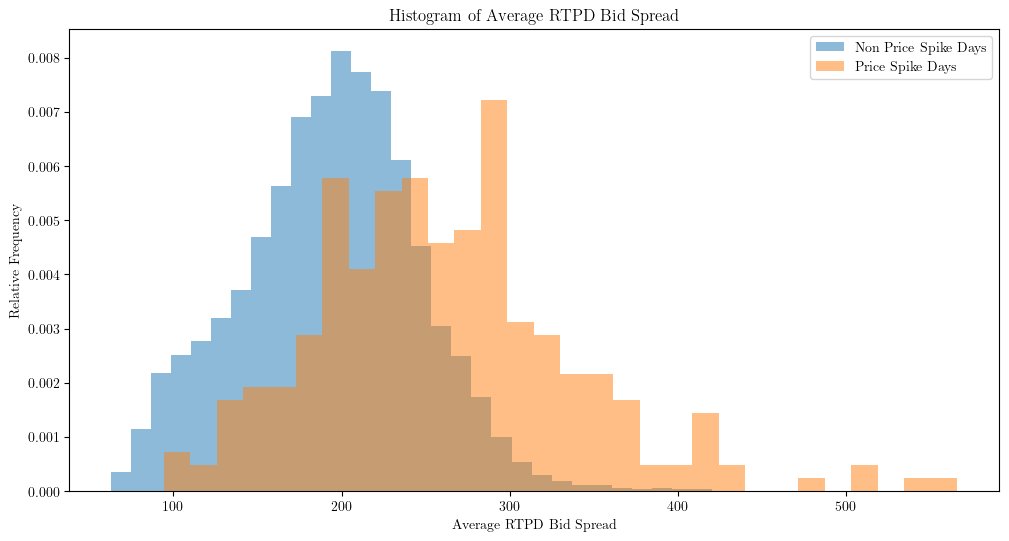

KS Statistic: 0.41279720279720283
P-value: 2.6894217974766363e-40
n price spike: 264
n non price spike: 10725


In [60]:
from scipy.stats import ks_2samp

# Separate the data into price spike days and non-price spike days
price_spike_hourly_index = hourly_df.index.floor("D").isin(RTP_spike_days_min)

# Plot the histograms
plt.figure(figsize=(12, 6))

# Histogram for non-price spike days
plt.hist(
    hourly_df[~price_spike_hourly_index]["bid_rtpd_weighted_spread"],
    bins=30,
    alpha=0.5,
    label="Non Price Spike Days",
    density=True,
)

# Histogram for price spike days
plt.hist(
    hourly_df[price_spike_hourly_index]["bid_rtpd_weighted_spread"],
    bins=30,
    alpha=0.5,
    label="Price Spike Days",
    density=True,
)

# Add title and labels
plt.title("Histogram of Average RTPD Bid Spread")
plt.xlabel("Average RTPD Bid Spread")
plt.ylabel("Relative Frequency")
plt.legend()

# Show the plot
plt.show()

# Extract the data for KS test
price_spike_data = (
    hourly_df[price_spike_hourly_index]["bid_rtpd_weighted_spread"].dropna().values
)
non_price_spike_data = (
    hourly_df[~price_spike_hourly_index]["bid_rtpd_weighted_spread"].dropna().values
)

# Perform the KS test
ks_statistic, p_value = ks_2samp(price_spike_data, non_price_spike_data)

# Print the results
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")
print("n price spike:", len(price_spike_data))
print("n non price spike:", len(non_price_spike_data))

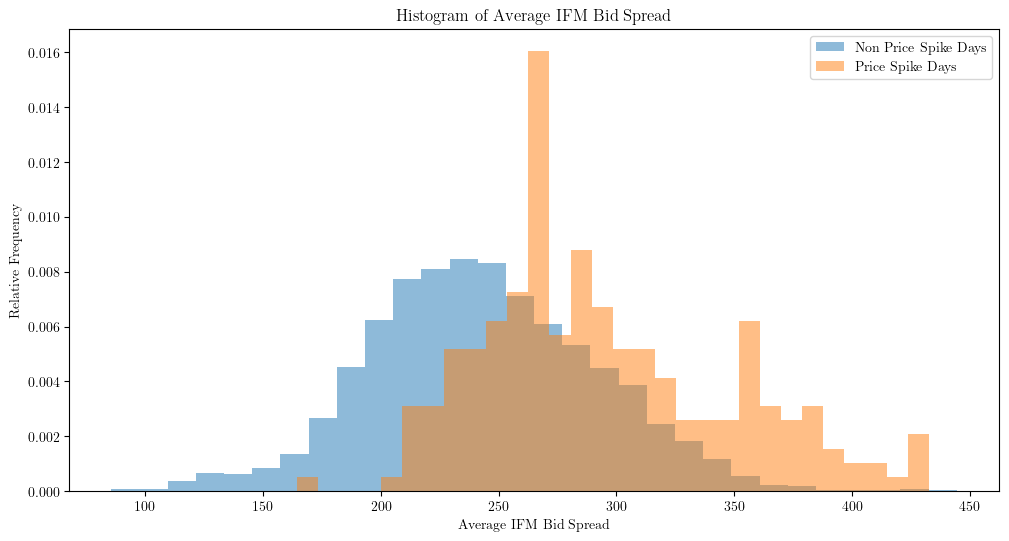

KS Statistic: 0.40762393796914953
P-value: 2.3586325237227303e-32
n price spike: 216
n non price spike: 10776


In [59]:
# Separate the data into price spike days and non-price spike days
price_spike_hourly_index = hourly_df.index.floor("D").isin(DAP_spike_days_min)

# Plot the histograms
plt.figure(figsize=(12, 6))

# Histogram for non-price spike days
plt.hist(
    hourly_df[~price_spike_hourly_index]["bid_ifm_weighted_spread"],
    bins=30,
    alpha=0.5,
    label="Non Price Spike Days",
    density=True,
)

# Histogram for price spike days
plt.hist(
    hourly_df[price_spike_hourly_index]["bid_ifm_weighted_spread"],
    bins=30,
    alpha=0.5,
    label="Price Spike Days",
    density=True,
)

# Add title and labels
plt.title("Histogram of Average IFM Bid Spread")
plt.xlabel("Average IFM Bid Spread")
plt.ylabel("Relative Frequency")
plt.legend()

# Show the plot
plt.show()

# Extract the data for KS test
price_spike_data = (
    hourly_df[price_spike_hourly_index]["bid_ifm_weighted_spread"].dropna().values
)
non_price_spike_data = (
    hourly_df[~price_spike_hourly_index]["bid_ifm_weighted_spread"].dropna().values
)

# Perform the KS test
ks_statistic, p_value = ks_2samp(price_spike_data, non_price_spike_data)

# Print the results
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")
print("n price spike:", len(price_spike_data))
print("n non price spike:", len(non_price_spike_data))